<a href="https://colab.research.google.com/github/Jules-gatete/RxMediq/blob/main/Summative_Intro_to_ml_Jules_Gatete_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Optimization Techniques in Machine Learning**

##**Objective**

This project explores the implementation of Machine Learning models with regularization, optimization, and error analysis techniques to improve model performance, convergence speed, and efficiency.

##**Project Overview**

**Dataset:**
 [Drug Prescription Dataset](https://www.kaggle.com/code/dharshanadhanendran/drugs-prediction-dataset/input)

**Task:** Multi-class classification of prescribed drugs based on patient characteristics.

**Approach:** Implement Neural Network models with and without optimization, followed by various optimization techniques.

**Evaluation Metrics**: Accuracy, Precision, Recall, F1-Score, Confusion Matrix.




------------------------------------------------------------------

**Import Necessary Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l1, l2
from sklearn.compose import ColumnTransformer
import joblib


**Load & Preprocess Data**

In [2]:
# Load the dataset
file_path = "/content/Drug prescription Dataset.csv"
df = pd.read_csv(file_path)

# Display basic info
print(df.head())
print(df.info())
print(df.describe())

    disease  age gender severity                drug
0  diarrhea    4   male      LOW  promegranate drink
1  diarrhea    4   male   NORMAL          lime juice
2  diarrhea    5   male      LOW  promegranate drink
3  diarrhea    5   male   NORMAL          lime juice
4  diarrhea    6   male      LOW  promegranate drink
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1288 entries, 0 to 1287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   disease   1288 non-null   object
 1   age       1288 non-null   int64 
 2   gender    1288 non-null   object
 3   severity  1288 non-null   object
 4   drug      1288 non-null   object
dtypes: int64(1), object(4)
memory usage: 50.4+ KB
None
               age
count  1288.000000
mean     33.645963
std      15.532570
min       4.000000
25%      20.000000
50%      34.000000
75%      47.000000
max      60.000000


In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 disease     0
age         0
gender      0
severity    0
drug        0
dtype: int64


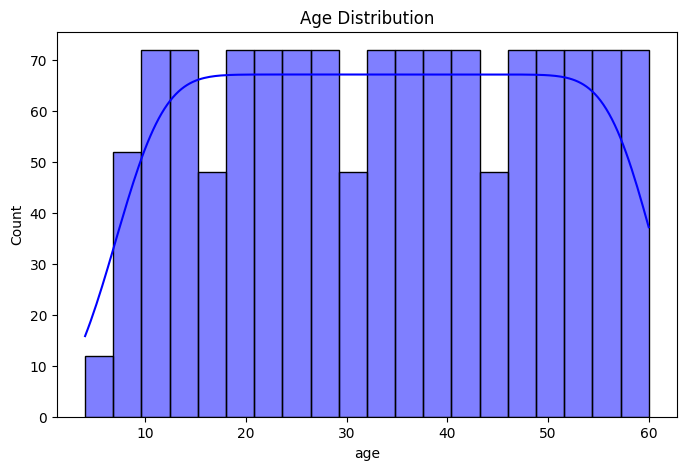

In [4]:
# Visualize the distribution of numerical data
plt.figure(figsize=(8, 5))
sns.histplot(df["age"], bins=20, kde=True, color="blue")
plt.title("Age Distribution")
plt.show()

In [5]:
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"Duplicate Rows: {duplicates}")

# Drop duplicates if any
df = df.drop_duplicates()


Duplicate Rows: 0


In [6]:
Q1 = df["age"].quantile(0.25)
Q3 = df["age"].quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter outliers
outliers = df[(df["age"] < lower_bound) | (df["age"] > upper_bound)]
print(f"Outliers detected in 'age': {len(outliers)}")


Outliers detected in 'age': 0


In [7]:
# Encode categorical variables and store mappings
label_encoders = {}
label_mappings = {}
categorical_columns = ["disease", "gender", "severity", "drug"]

for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = dict(enumerate(le.classes_))  # Save mapping

# Split dataset into features and target variable
X = df.drop(columns=["drug"])  # Features
y = df["drug"]  # Target variable

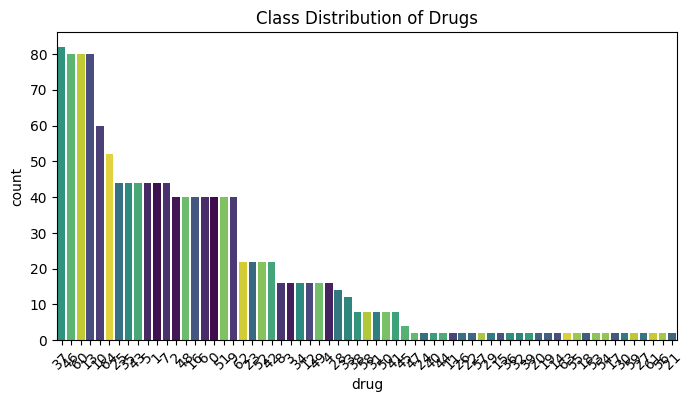

In [8]:
plt.figure(figsize=(8, 4))
sns.countplot(x=df["drug"], hue=df["drug"], palette="viridis", order=df["drug"].value_counts().index, legend=False)
plt.title("Class Distribution of Drugs")
plt.xticks(rotation=45)
plt.show()

In [9]:
# Split dataset into features and target variable
X = df.drop(columns=["drug"])  # Features
y = df["drug"]  # Target variable

# Step 1: Split into 60% training and 40% temporary (validation + test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.40, random_state=42, stratify=y)

# Step 2: Ensure stratification is only used if class count >1
class_counts = y_temp.value_counts()
stratify_param = y_temp if class_counts.min() >= 2 else None

# Step 3: Split the 40% temporary set into 20% validation and 20% test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=stratify_param)

In [10]:
# Fix SettingWithCopyWarning
X_train = X_train.copy()
X_val = X_val.copy()
X_test = X_test.copy()

In [11]:
# Define transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ["age"]),  # Scale age
        ('cat', "passthrough", X.columns.difference(["age"]))  # Keep categorical as is
    ]
)

# Apply transformation
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


In [12]:
# Print dataset sizes
dataset_sizes = {
    "Training data": X_train.shape[0],
    "Validation data": X_val.shape[0],
    "Testing data": X_test.shape[0]
}

print(f"Training data: {X_train.shape[0]} samples")
print(f"Validation data: {X_val.shape[0]} samples")
print(f"Testing data: {X_test.shape[0]} samples")

Training data: 772 samples
Validation data: 258 samples
Testing data: 258 samples


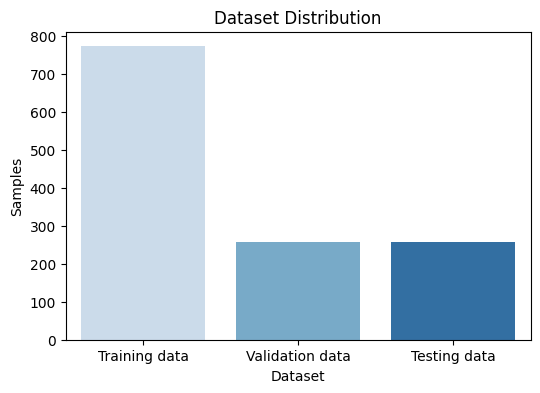

In [13]:
# Convert dataset sizes to DataFrame for visualization
df_sizes = pd.DataFrame(dataset_sizes.items(), columns=["Dataset", "Samples"])

# Plot the dataset size distribution
plt.figure(figsize=(6, 4))
sns.barplot(x="Dataset", y="Samples", hue="Dataset", data=df_sizes, palette="Blues", dodge=False)
plt.title("Dataset Distribution")
plt.xlabel("Dataset")
plt.ylabel("Samples")
plt.show()


# **SECTION 1: Model Architecture:**

#**Mode's Architecture**

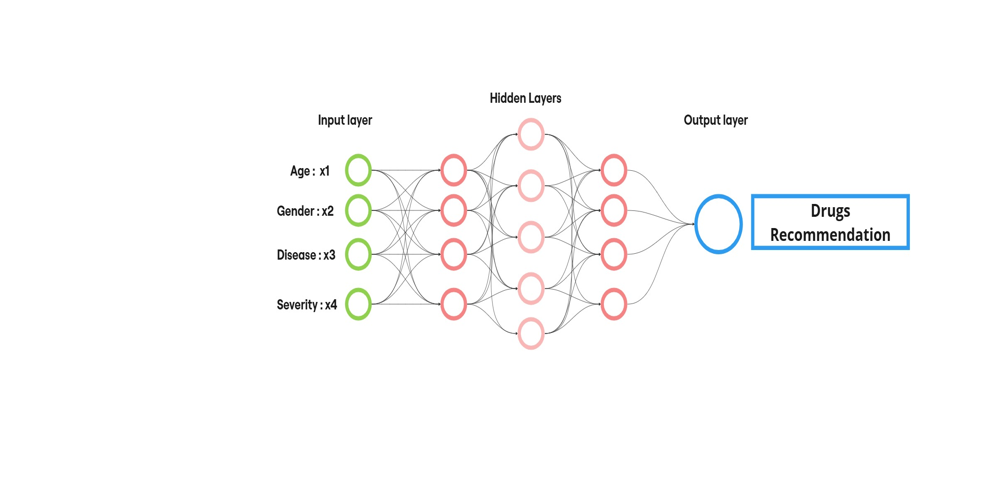

In [99]:
from IPython.display import display
from PIL import Image

# ✅ Load and display the image
image_path = "/content/Model architecture Diagram_RxMediq.jpg"
img = Image.open(image_path)
img = img.resize((1000, 500))  # Resize width x height
display(img)



# 📌 Function to train and evaluate models


In [14]:
# Function to evaluate models
def evaluate_model(model, X_test, y_test, model_name, history=None):
    # Calculate loss only for Keras models (Sequential)
    loss = None  # Initialize loss to None
    if isinstance(model, Sequential):
        loss = model.evaluate(X_test, y_test, verbose=0)[0]

    y_pred = model.predict(X_test)
    if isinstance(model, Sequential):
        y_pred = np.argmax(y_pred, axis=1)

    metrics = {
        "Loss": loss,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=1),
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=1),
        "F1 Score": f1_score(y_test, y_pred, average='weighted'),
        "Confusion Matrix": confusion_matrix(y_test, y_pred)
    }

    print(f"\n📊 Performance Metrics - {model_name}:")
    # Print loss only if it's not None (for Keras models)
    if loss is not None:
        print(f"Loss: {loss:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")

    # Plot accuracy training history for all models
    if isinstance(model, Sequential) and history is not None:
        plt.figure(figsize=(8, 5))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.title(f"Training History - {model_name}")
        plt.legend()
        plt.show()

    # Plot Confusion Matrix for all models, including Logistic Regression
    plt.figure(figsize=(8, 6))
    sns.heatmap(metrics["Confusion Matrix"], annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return metrics

#**Implementing** **Models**



## Logistic Regression (Classical ML)



📊 Performance Metrics - Final Optimized Logistic Regression:
Accuracy: 0.6783
Precision: 0.7016
Recall: 0.6783
F1 Score: 0.6377


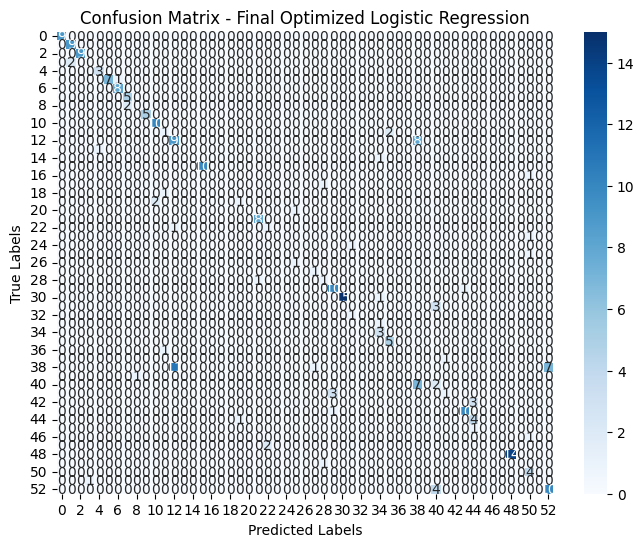

In [60]:
from sklearn.preprocessing import StandardScaler

# Apply scaling only to numerical features
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()
X_train_scaled[:, 0] = scaler.fit_transform(X_train[:, 0].reshape(-1, 1)).flatten()
X_test_scaled[:, 0] = scaler.transform(X_test[:, 0].reshape(-1, 1)).flatten()

# Train Logistic Regression with better hyperparameters
log_reg = LogisticRegression(max_iter=5000, solver='saga', C=1.5, class_weight=None)
log_reg.fit(X_train_scaled, y_train)

# Evaluate the updated model
log_reg_metrics = evaluate_model(log_reg, X_test_scaled, y_test, "Final Optimized Logistic Regression")


## Simple Neural Network (No Optimization) =





9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

📊 Performance Metrics - Simple Neural Network:
Loss: 0.7201
Accuracy: 0.8411
Precision: 0.9036
Recall: 0.8411
F1 Score: 0.8214


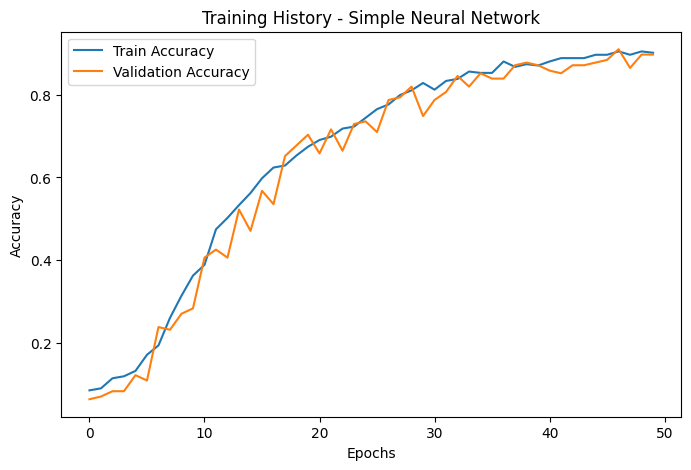

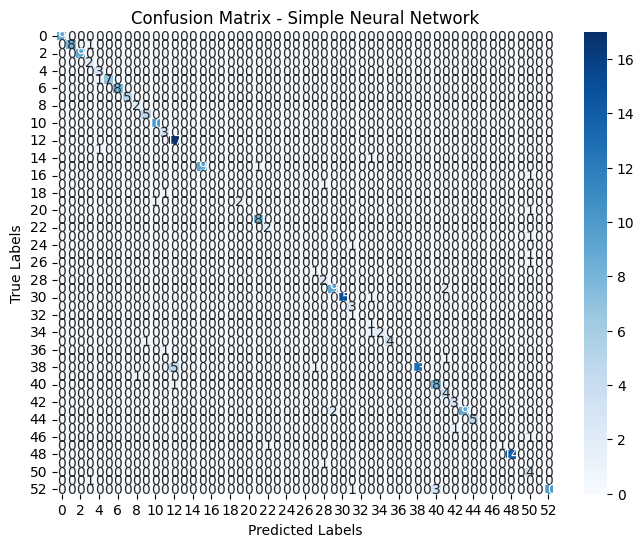

In [62]:
simple_nn = Sequential([
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(len(np.unique(y)), activation='softmax')
])

simple_nn.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = simple_nn.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

simple_nn_metrics = evaluate_model(simple_nn, X_test, y_test, "Simple Neural Network", history)


# **Optimized Neural Networks**

## Model 1: Adam Optimizer + L1 Regularization


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

📊 Performance Metrics - Adam + L1 Regularization:
Loss: 0.8767
Accuracy: 0.9031
Precision: 0.9390
Recall: 0.9031
F1 Score: 0.8808


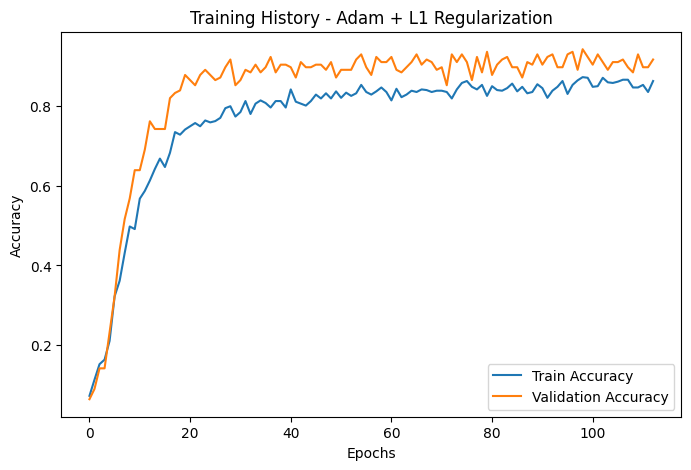

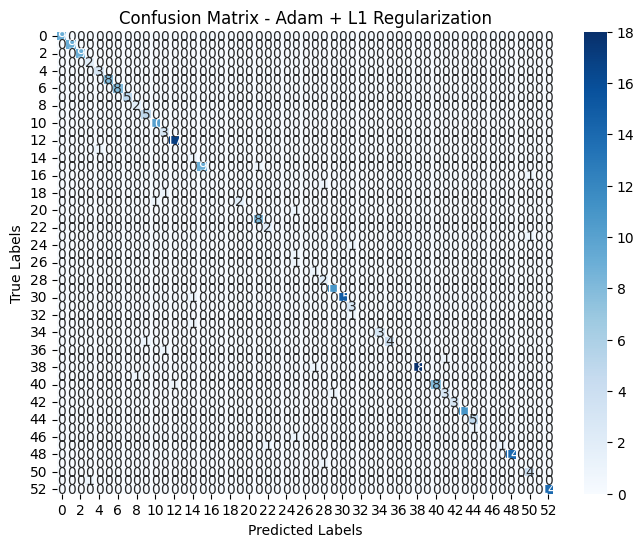

In [58]:
adam_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.001)),  # Restored L1 to 0.001
    Dropout(0.1),  # Reduced Dropout
    Dense(48, activation='relu', kernel_regularizer=l1(0.001)),  # New hidden layer
    Dropout(0.1),  # Reduced Dropout
    Dense(32, activation='relu', kernel_regularizer=l1(0.001)),
    Dense(len(np.unique(y)), activation='softmax')
])

adam_l1_model.compile(optimizer=Adam(learning_rate=0.0017),  # Slightly increased LR
                      loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_adam = adam_l1_model.fit(X_train, y_train, epochs=250, batch_size=32, validation_split=0.2, verbose=0,
                                 callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

adam_l1_metrics = evaluate_model(adam_l1_model, X_test, y_test, "Adam + L1 Regularization", history_adam)


## Model 2: RMSProp Optimizer + L2 Regularization




9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

📊 Performance Metrics - RMSProp + L2 Regularization:
Loss: 0.8198
Accuracy: 0.8953
Precision: 0.9361
Recall: 0.8953
F1 Score: 0.8704


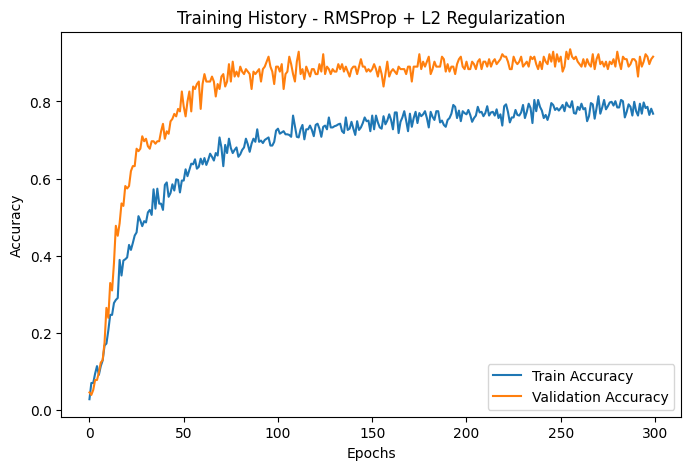

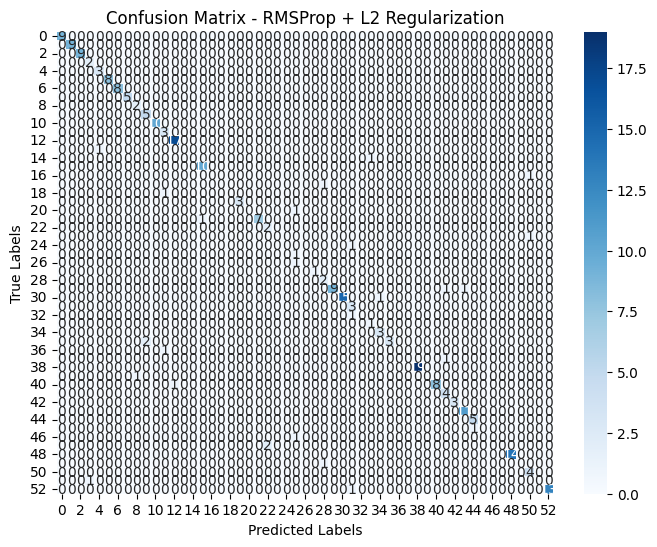

In [54]:
rmsprop_l2_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(48, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.005)),
    Dense(len(np.unique(y)), activation='softmax')
])

rmsprop_l2_model.compile(optimizer=RMSprop(learning_rate=0.001),
                         loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_rmsprop = rmsprop_l2_model.fit(X_train, y_train, epochs=300, batch_size=24, validation_split=0.2, verbose=0,
                                       callbacks=[EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)])

rmsprop_l2_metrics = evaluate_model(rmsprop_l2_model, X_test, y_test, "RMSProp + L2 Regularization", history_rmsprop)


## Model 3: SGD Optimizer + L1 Regularization


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

📊 Performance Metrics - SGD + L1 Regularization:
Loss: 1.2266
Accuracy: 0.8566
Precision: 0.9076
Recall: 0.8566
F1 Score: 0.8291


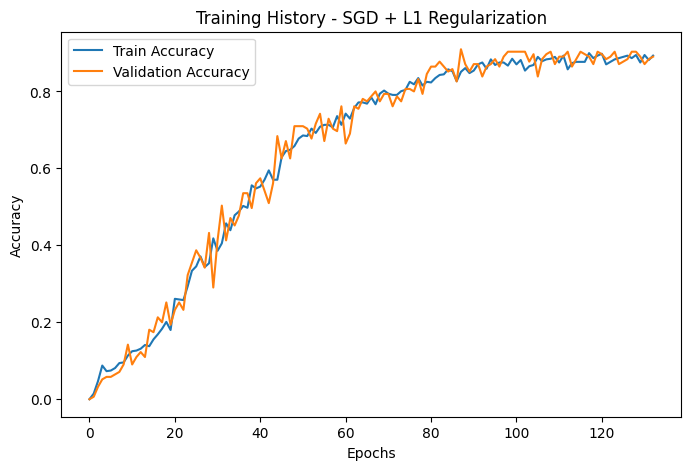

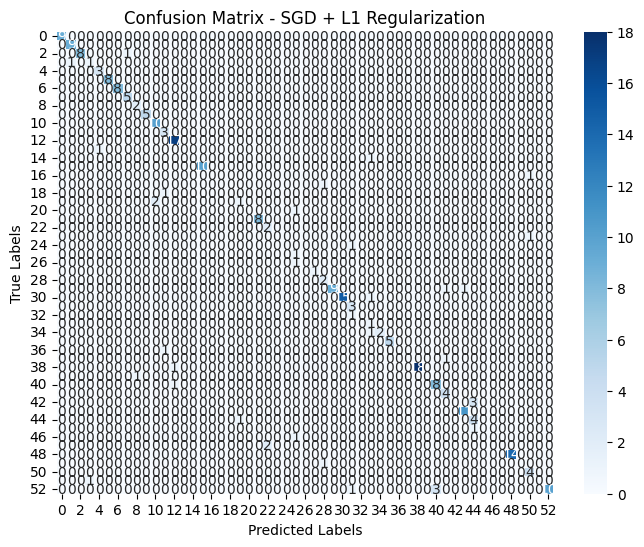

In [56]:
sgd_l1_model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l1(0.005)),
    Dense(48, activation='relu', kernel_regularizer=l1(0.005)),
    Dense(32, activation=LeakyReLU(alpha=0.1), kernel_regularizer=l1(0.005)),
    Dense(len(np.unique(y)), activation='softmax')
])

sgd_l1_model.compile(optimizer=SGD(learning_rate=0.005, momentum=0.8),
                     loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_sgd = sgd_l1_model.fit(X_train, y_train, epochs=200, batch_size=24, validation_split=0.2, verbose=0,
                               callbacks=[EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)])

sgd_l1_metrics = evaluate_model(sgd_l1_model, X_test, y_test, "SGD + L1 Regularization", history_sgd)


# **Save Models**

In [69]:
from tensorflow.keras.models import save_model

# Save the best Neural Network Models
save_model(adam_l1_model, "saved_models/best_model_adam.h5")
save_model(rmsprop_l2_model, "saved_models/best_model_rmsprop.h5")
save_model(sgd_l1_model, "saved_models/best_model_sgd.h5")
save_model(simple_nn, "saved_models/simple_nn.h5")

# Save Logistic Regression Model
joblib.dump(log_reg, "saved_models/logistic_regression.pkl")


['saved_models/logistic_regression.pkl']

#**🚀 Model Selection & Prediction**



Downloading the Saved Models

In [71]:
!zip -r saved_models.zip saved_models/
from google.colab import files
files.download("saved_models.zip")


  adding: saved_models/ (stored 0%)
  adding: saved_models/best_model_rmsprop.h5 (deflated 40%)
  adding: saved_models/logistic_regression.pkl (deflated 17%)
  adding: saved_models/best_model_sgd.h5 (deflated 39%)
  adding: saved_models/best_model_adam.h5 (deflated 32%)
  adding: saved_models/simple_nn.h5 (deflated 40%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Save the Best Performing Model


In [88]:
# Define Best Model Based on Performance
best_model = adam_l1_model  # Adam + L1 Regularization had the best accuracy (90.31%)

print("Best model selected: Adam + L1 Regularization")

Best model selected: Adam + L1 Regularization


In [89]:
# ✅ Save the Best Performing Model
best_model_path = "saved_models/best_model_final.h5"
save_model(best_model, best_model_path)

print(f"✅ Best model saved at: {best_model_path}")


✅ Best model saved at: saved_models/best_model_final.h5


In [90]:
from google.colab import files

# ✅ Download the saved model
files.download(best_model_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
# ✅ Load the Saved Model
best_model = load_model("saved_models/best_model_final.h5")

# ✅ Verify Model Structure
best_model.summary()

Model: "sequential_42"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_131 (Dense)                    │ (None, 64)                  │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_52 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_132 (Dense)                    │ (None, 48)                  │           3,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_53 (Dropout)                 │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_133 (Dense)                    │ (None, 32)                  │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_134 (Dense)                    │ (None, 65)                  │           2,145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,155 (27.95 KB)

 Trainable params: 7,153 (27.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [86]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Make Predictions
y_pred_probs = best_model.predict(X_test)  # Get softmax probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels

# ✅ Convert Predictions & Actual Labels Back to Original Categories
y_test_original = [label_encoders["drug"].inverse_transform([label])[0] for label in y_test]
y_pred_original = [label_encoders["drug"].inverse_transform([label])[0] for label in y_pred]

# ✅ Create a DataFrame to Show Side-by-Side Results
predictions_df = pd.DataFrame({
    "Actual Drug Prescribed": y_test_original,
    "Predicted Drug Prescribed": y_pred_original
})

# ✅ Display Sample of Predictions
print("\n📊 Sample Predictions - Best Model\n")
print(predictions_df.head(10))  # Show first 10 rows


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

📊 Sample Predictions - Best Model

      Actual Drug Prescribed  Predicted Drug Prescribed
0  Anu Taila + Shankhapushpi  Anu Taila + Shankhapushpi
1             ashta choornam             ashta choornam
2               Mukta pishti               Mukta pishti
3                akik pishti                akik pishti
4                akik pishti                akik pishti
5             trikatu churna             trikatu churna
6             trikatu churna             trikatu churna
7              kamdhudha ras              kamdhudha ras
8             trikatu churna             trikatu churna
9             fenugreek seed             fenugreek seed
